In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import glob

In [2]:
cernbox = '/Users/emiliebertholet/cernbox/coldbox_data'

## rawdata
# file = f'{cernbox}/adc_data_run_25036_ch_40_all.npy'
# data = np.load(file, allow_pickle=True).astype(np.int16)
# data.shape

## after wf. extraction
path = f'{cernbox}/selected_waveforms/selection_PNS_wlenNone_prom500.pkl' 

# path = f'{cernbox}/selected_waveforms/selection_PNS_neutrons_wlenNone_prom500.pkl'
# path = f'{cernbox}/selected_waveforms/selection_PNS_SideBand_wlenNone_prom500.pkl'

with open(path, 'rb') as file:
    data = pickle.load(file)
# data = pd.DataFrame(dic)
# print(f"PNS:  {data.shape[0]} pulses, {data.trigger_record.unique().shape[0]} trigger records")
print(data.keys())
print( len(data['waveform']) )

dict_keys(['trigger_record', 'waveform_index', 'height', 'width', 'pedestal', 'waveform'])
46228


In [3]:
def pad_waveforms(input_data, pad_length=500):
    output_data = input_data
    output_data['waveform_padded'] = [np.pad(wf, (0, pad_length - len(wf))) if len(wf) < pad_length else wf[:pad_length] for wf in output_data['waveform']]
    return output_data

pad_waveforms(data, 500);



## Clean Waveforms

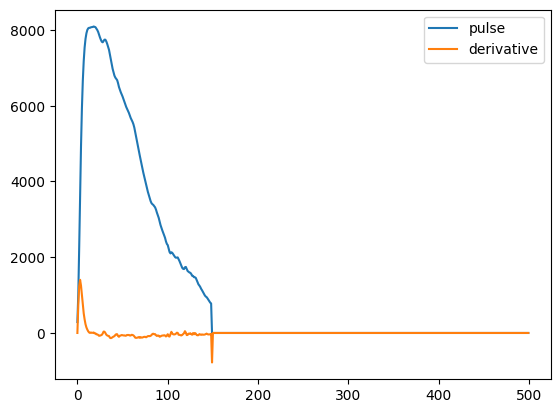

In [4]:
i = 200
test = np.array(data['waveform_padded'])[i]
deriv = np.diff(test, prepend=test[0])
plt.plot(test, label='pulse')
plt.plot(deriv, label='derivative')
plt.legend()

In [5]:
def add_rising_edges(data):
    pulses_sel = np.array(data['waveform_padded'])
    first_rising_edge_idxs, first_rising_edge_vals = [], []
    second_rising_edge_idxs, second_rising_edge_vals = [], []
    derivatives = []
    for wf in pulses_sel:
        deriv = np.diff(wf, prepend=wf[0])
        first_rising_edge_idx = np.argmax(deriv)
        derivatives.append(deriv)
        first_rising_edge_idxs.append(first_rising_edge_idx)
        first_rising_edge_vals.append(deriv[first_rising_edge_idx])

        exclusion_width=10
        deriv_masked = deriv.copy()
        start = max(0, first_rising_edge_idx - exclusion_width)
        end = min(len(deriv), first_rising_edge_idx + exclusion_width + 1)
        deriv_masked[start:end] = 0 # replace the first maximum region by 0
        second_rising_edge_idx = np.argmax(deriv_masked)

        second_rising_edge_idxs.append(second_rising_edge_idx)
        second_rising_edge_vals.append(deriv_masked[second_rising_edge_idx])

    data['first_rising_edge_idx']  = np.array(first_rising_edge_idxs)
    data['second_rising_edge_idx'] = np.array(second_rising_edge_idxs)
    data['first_rising_edge_val']  = np.array(first_rising_edge_vals)
    data['second_rising_edge_val'] = np.array(second_rising_edge_vals)
    data['derivatives']            = np.array(derivatives)


In [6]:
add_rising_edges(data)

Text(0.5, 1.0, '2nd rising edge')

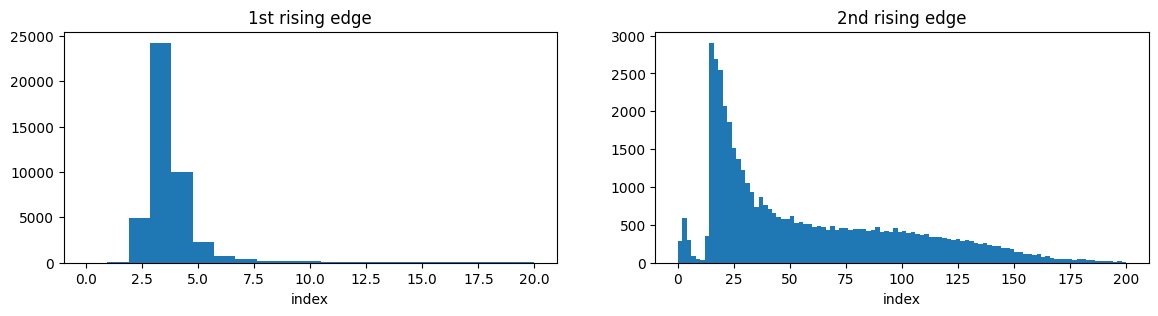

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 3))
axs[0].hist(data['first_rising_edge_idx'], bins=21, range = (0,20), label='1st edge');
axs[1].hist(data['second_rising_edge_idx'], bins=100, range = (0,200), label='2nd edge');
axs[0].set_xlabel('index')
axs[0].set_title('1st rising edge')
axs[1].set_xlabel('index')
axs[1].set_title('2nd rising edge')

1st val mean = 298.872350090854
2nd val mean = 38.67032967032967


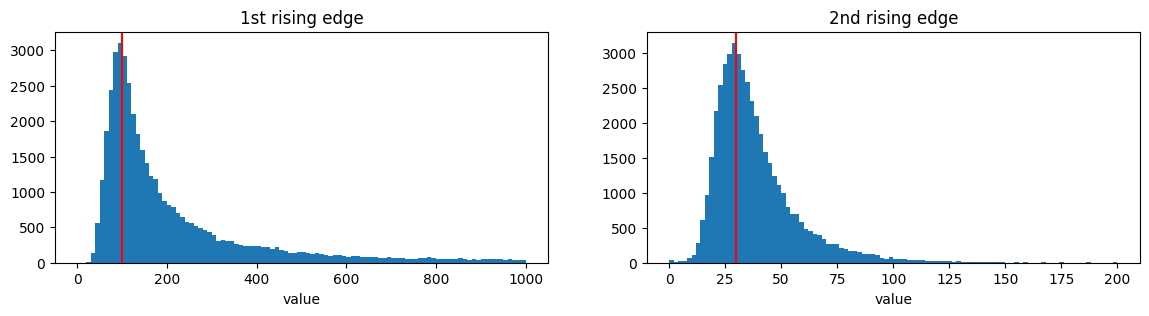

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(14, 3))
axs[0].hist(data['first_rising_edge_val'],  bins=100, range = (0, 1000), label='1st edge');
axs[0].axvline(x = 100, color='red')
axs[1].hist(data['second_rising_edge_val'], bins=100, range = (0, 200), label='2nd edge');
axs[1].axvline(x = 30, color='red')
axs[0].set_xlabel('value')
axs[0].set_title('1st rising edge')
axs[1].set_xlabel('value')
axs[1].set_title('2nd rising edge');


print(f'1st val mean = {data['first_rising_edge_val'].mean()}')
print(f'2nd val mean = {data['second_rising_edge_val'].mean()}')

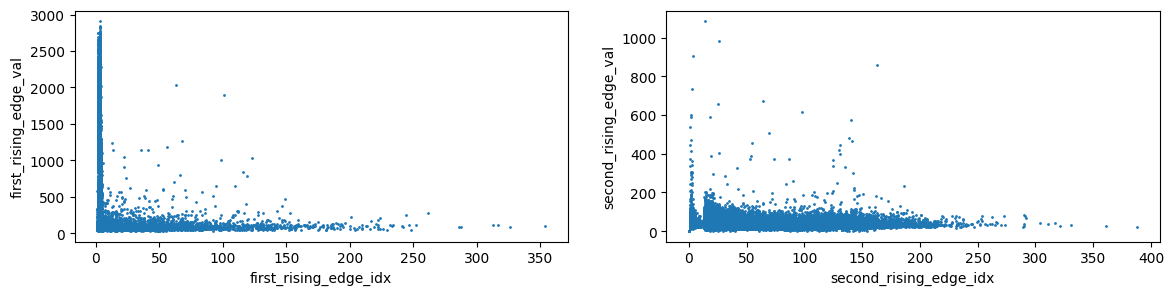

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 3))
axs[0].scatter(data['first_rising_edge_idx'], data['first_rising_edge_val'], s=1);
axs[0].set_xlabel('first_rising_edge_idx')
axs[0].set_ylabel('first_rising_edge_val')

axs[1].scatter(data['second_rising_edge_idx'], data['second_rising_edge_val'], s=1);
axs[1].set_xlabel('second_rising_edge_idx')
axs[1].set_ylabel('second_rising_edge_val');


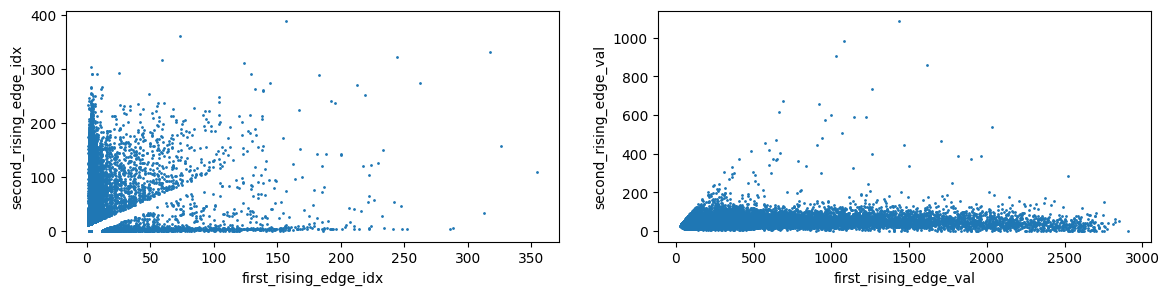

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14, 3))
axs[0].scatter(data['first_rising_edge_idx'], data['second_rising_edge_idx'], s=1);
axs[0].set_xlabel('first_rising_edge_idx')
axs[0].set_ylabel('second_rising_edge_idx')

axs[1].scatter(data['first_rising_edge_val'], data['second_rising_edge_val'], s=1);
axs[1].set_xlabel('first_rising_edge_val')
axs[1].set_ylabel('second_rising_edge_val');

31959 46228
retention rate 69.1%


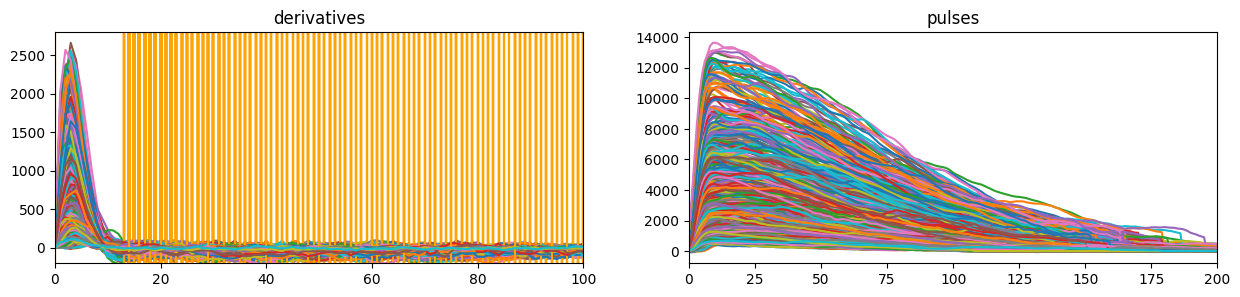

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))

# mask = (data['second_rising_edge_idx']<10)
# mask = ( (data['first_rising_edge_idx']<25) | (data['second_rising_edge_idx']<10) )

mask = (data['first_rising_edge_idx']<10) & (data['first_rising_edge_val']>100) & (data['second_rising_edge_val']<100) 

waveforms_sel     = np.array(data['waveform_padded'])[mask]
derivatives_sel   = data['derivatives'][mask]
firstEdgeIdx_sel  = data['first_rising_edge_idx'][mask]
SecondEdgeIdx_sel = data['second_rising_edge_idx'][mask]
firstEdgeVal_sel  = data['first_rising_edge_val'][mask]
SecondEdgeVal_sel = data['second_rising_edge_val'][mask]

tot = np.array(data['waveform_padded']).shape[0]
sel = waveforms_sel.shape[0]
print(sel, tot)
print(f'retention rate {sel*100/tot:.1f}%')

rg = (0, 2000) if sel >= 2000 else (0, sel)

ax = axs[0]
for i in range(rg[0], rg[1]):  
    axs[0].plot(derivatives_sel[i])
    # axs[0].axhline(y = firstEdgeVal_sel[i])
    # axs[0].axhline(y = SecondEdgeVal_sel[i], color = 'orange')
    # axs[0].axvline(x = firstEdgeIdx_sel[i])
    axs[0].axvline(x = SecondEdgeIdx_sel[i], color = 'orange')

    axs[1].plot(waveforms_sel[i])
    # axs[1].axvline(x = firstEdgeIdx_sel[i])
    # axs[1].axvline(x = SecondEdgeIdx_sel[i], color = 'orange')

    axs[0].set_xlim(0, 100)
    axs[0].set_ylim(-200, 2800)
    axs[0].set_title('derivatives')
    axs[1].set_xlim(0, 200)
    axs[1].set_title('pulses')


31959 46228
retention rate 35.5%


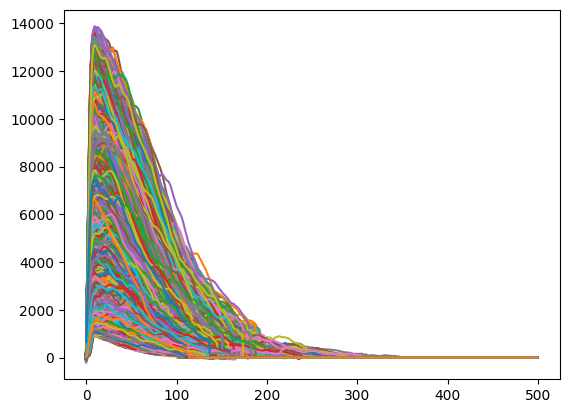

In [53]:
# mask = (data['first_rising_edge_idx'] < 25) & (data['first_rising_edge_val'] > 100) & (data['second_rising_edge_val']<80) & (data['first_rising_edge_val']>80)

# mask = (data['first_rising_edge_idx']<10) & (data['first_rising_edge_val']>100) & (data['second_rising_edge_val']<100) 

mask = (data['first_rising_edge_idx']<8) & (data['first_rising_edge_val']>200) & (data['second_rising_edge_val']<100) 

pulses_sel = np.array(data['waveform_padded'])
selected_waveforms = pulses_sel[mask]

Ntot = pulses_sel.shape[0]
Nsel = selected_waveforms.shape[0]
print(sel, tot)
print(f'retention rate {Nsel*100/Ntot:.1f}%')

for i in range(len(selected_waveforms)):   
    plt.plot(selected_waveforms[i])

# Find Integration boundaries

193
2 194


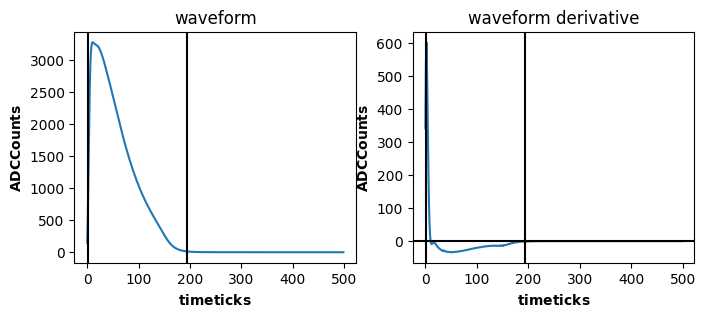

In [54]:
## find integration window (Vitaliy's method)
# 1. Get derivative of avg. waveform
# 2. Selecting the interval between the spike (rising edge) and “getting back to 0” for the waveform derivative

# pulses_sel = pulses_bs
# selected_waveforms = data['waveform_padded']

avg_wf      = np.mean(selected_waveforms, axis=0)
avg_wf_diff = np.diff(avg_wf)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
ax = axs[0]
ax.plot(np.arange(0, len(avg_wf), 1), avg_wf);
ax.set_xlabel(r"$\mathrm{\bf time ticks}$");
ax.set_ylabel(r"$\mathrm{\bf ADC Counts}$");
ax.set_title(r"waveform");
# ax.set_xlim(0, 400)

rising_edge_idx = np.argmax(avg_wf_diff)
bound_min = np.argmax(avg_wf_diff) # rising edge
min_idx = np.argmin(avg_wf_diff)
epsilon = 1
for i in range(min_idx, len(avg_wf_diff)):
    if abs(avg_wf_diff[i]) < epsilon:
        print(i)
        bound_max = i + 1
        break

ax.axvline(x=bound_min, color='black')
ax.axvline(x=bound_max, color='black')
ax = axs[1]
ax.plot(np.arange(0, len(avg_wf_diff), 1), avg_wf_diff);
ax.axhline(y=0, color='black')
ax.set_xlabel(r"$\mathrm{\bf time ticks}$");
ax.set_ylabel(r"$\mathrm{\bf ADC Counts}$");
ax.set_title(r"waveform derivative");
ax.axvline(x=bound_min, color='black')
ax.axvline(x=bound_max, color='black');

print(bound_min, bound_max)


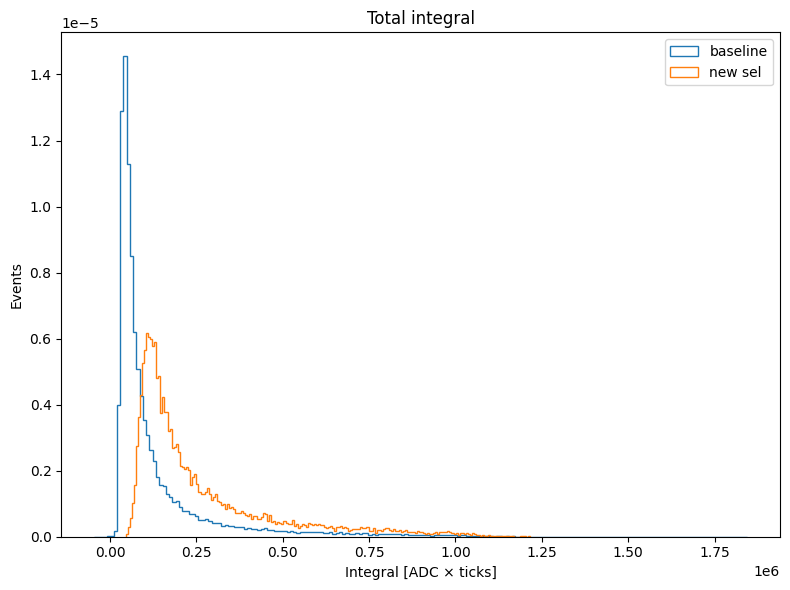

In [55]:
# bound_max = 50
integrals_baseline = np.sum(pulses_sel[:, 2:210], axis=1)
integrals = np.sum(selected_waveforms[:, bound_min:bound_max], axis=1)

plt.figure(figsize=(8, 6))
# rg = (0, np.max(integrals)*1.1)
# rg =(-1000, 3000)
rg = None
plt.hist( integrals_baseline, bins=200, range=rg, histtype='step', label='baseline', density=True)
plt.hist( integrals, bins=200, range=rg, histtype='step', label='new sel', density=True)
plt.xlabel("Integral [ADC × ticks]")
plt.ylabel("Events")
plt.title("Total integral")
plt.tight_layout()
plt.legend()
plt.show()

In [56]:
# data.keys()

# 1tt = 16ns
# -0.3us = -300ns = peak-19tt
#  0.5us =  500ns = peak+31

In [57]:
10

10

baseline
 (bound min, bound max), (2, 192)
 prompt (min, max), (-2, 28)
baseline
 (bound min, bound max), (2, 194)
 prompt (min, max), (-9, 21)


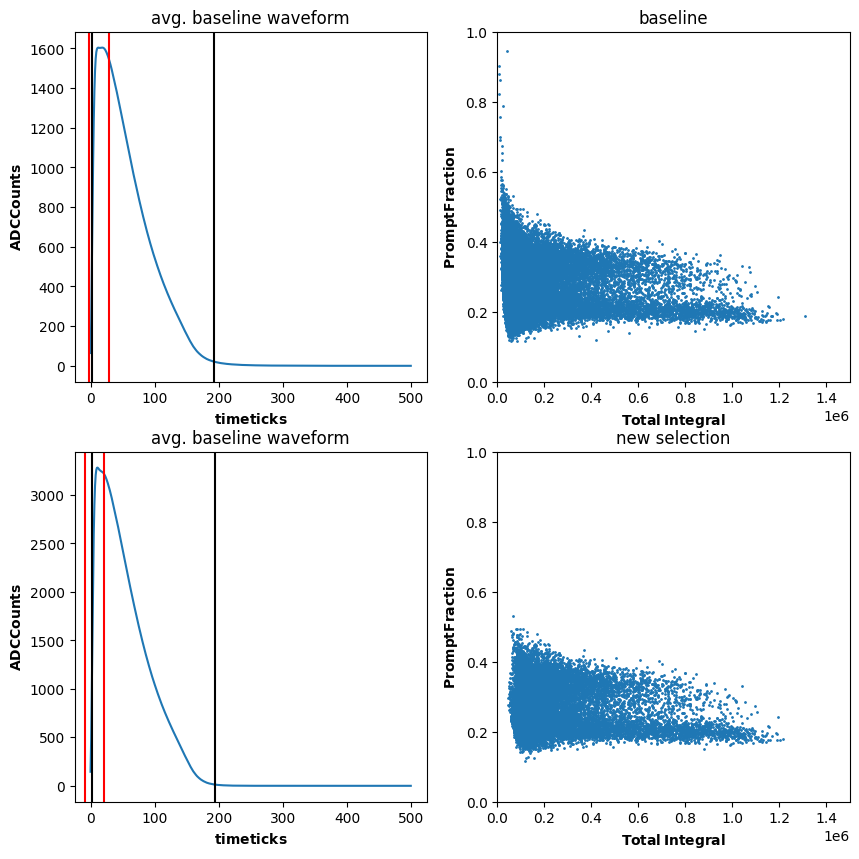

In [58]:

def get_bounaries(avg_wf_diff):
    bound_min = np.argmax(avg_wf_diff) # rising edge
    min_idx = np.argmin(avg_wf_diff)
    epsilon = 1
    for i in range(min_idx, len(avg_wf_diff)):
        if abs(avg_wf_diff[i]) < epsilon:
            bound_max = i + 1
            break
    return bound_min, bound_max

def prompt_frac(waveforms, tot_int_boundaries, prompt_int_boundaries):
    promptFrac, Int, ratio = [], [], []
    for p in waveforms:
        peak_position = p.argmax()
        lim_inf = peak_position+prompt_int_boundaries[0]
        lim_sup = peak_position+prompt_int_boundaries[1]
        if lim_inf<0:
            lim_inf = 0
        pf = p[lim_inf:lim_sup].sum()
        integ = p[tot_int_boundaries[0]:tot_int_boundaries[1]].sum()
        r = pf/integ
        promptFrac.append( pf )
        Int.append( integ )
        ratio.append( r )
    return np.array(Int), np.array(ratio)




fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# prompt_boundaries = (-19, 31)
prompt_boundaries = (-20,  10)

ax = axs.flatten()[0]
avg_wf_baseline      = np.mean(np.array(data['waveform_padded']), axis=0)
avg_wf_diff_baseline = np.diff(avg_wf_baseline)
ax.plot(np.arange(0, len(avg_wf_baseline), 1), avg_wf_baseline);
bmin_baseline, bmax_baseline = get_bounaries(avg_wf_diff_baseline)
print('baseline')
print(f' (bound min, bound max), ({bmin_baseline}, {bmax_baseline})')
ax.axvline(x=bmin_baseline, color='black')
ax.axvline(x=bmax_baseline, color='black');
peak_position = avg_wf_baseline.argmax()
lim_inf = peak_position+prompt_boundaries[0]
lim_sup = peak_position+prompt_boundaries[1]
print(f' prompt (min, max), ({lim_inf}, {lim_sup})')
ax.axvline(x=lim_inf, color='red')
ax.axvline(x=lim_sup, color='red');
ax.set_xlabel(r"$\mathrm{\bf time ticks}$");
ax.set_ylabel(r"$\mathrm{\bf ADC Counts}$");
ax.set_title(r"avg. baseline waveform");

ax = axs.flatten()[1]
Int_baseline, ratio_baseline = prompt_frac(np.array(data['waveform_padded']), (bmin_baseline, bmax_baseline), prompt_boundaries)
ax.scatter(Int_baseline, ratio_baseline,  s=1)
ax.set_xlabel(r"$\mathrm{\bf Total \, Integral}$")
ax.set_ylabel(r"$\mathrm{\bf Prompt Fraction}$");
ax.set_title("baseline")
ax.set_ylim(0, 1.0);
ax.set_xlim(0, 1.5e6);

ax = axs.flatten()[2]
avg_wf      = np.mean(selected_waveforms, axis=0)
avg_wf_diff = np.diff(avg_wf)
ax.plot(np.arange(0, len(avg_wf), 1), avg_wf);
bmin, bmax = get_bounaries(avg_wf_diff)
print('baseline')
print(f' (bound min, bound max), ({bmin}, {bmax})')
ax.axvline(x=bmin, color='black')
ax.axvline(x=bmax, color='black');
peak_position = avg_wf.argmax()
lim_inf = peak_position+prompt_boundaries[0]
lim_sup = peak_position+prompt_boundaries[1]
print(f' prompt (min, max), ({lim_inf}, {lim_sup})')
ax.axvline(x=lim_inf, color='red')
ax.axvline(x=lim_sup, color='red');
ax.set_xlabel(r"$\mathrm{\bf time ticks}$");
ax.set_ylabel(r"$\mathrm{\bf ADC Counts}$");
ax.set_title(r"avg. baseline waveform");

ax = axs.flatten()[3]
I, R = prompt_frac(selected_waveforms, (bmin, bmax), prompt_boundaries)

ax.scatter(I, R,  s=1)
ax.set_title("new selection")
ax.set_xlabel(r"$\mathrm{\bf Total \, Integral}$")
ax.set_ylabel(r"$\mathrm{\bf Prompt Fraction}$");
ax.set_ylim(0, 1.0);
ax.set_xlim(0, 1.5e6);